# Leaf Disease Prediction & Evaluation

Ce notebook permet de charger le modèle entraîné et de faire des prédictions sur de nouvelles images.

## 1. Configuration de l'Environnement

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings
import zipfile
from tensorflow.keras.models import load_model
import tensorflow as tf
import logging
from sklearn.metrics import accuracy_score, classification_report
import shutil
from pathlib import Path

warnings.filterwarnings("ignore", category=UserWarning, module='tensorflow')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

tf.get_logger().setLevel(logging.ERROR)

print("Imports terminés")

2025-12-15 11:50:42.166458: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-15 11:50:42.195701: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-15 11:50:44.613174: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


Imports terminés


## 2. Fonctions de Transformation d'Images

In [2]:
def gaussian_blur(image):
    """Applique un flou gaussien."""
    return cv2.GaussianBlur(image, (15, 15), 0)


def mask_image(image):
    """Crée un masque binaire."""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY)
    return cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)


def roi_objects(image):
    """Dessine les contours ROI."""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_TREE,
                                   cv2.CHAIN_APPROX_SIMPLE)
    roi_image = image.copy()
    cv2.drawContours(roi_image, contours, -1, (0, 255, 0), 3)
    return roi_image


def analyze_object(image):
    """Analyse les objets et marque les centroïdes."""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_TREE,
                                   cv2.CHAIN_APPROX_SIMPLE)
    analyze_image = image.copy()
    for contour in contours:
        M = cv2.moments(contour)
        if M["m00"] != 0:
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])
            cv2.circle(analyze_image, (cx, cy), 5, (0, 0, 255), -1)
    return analyze_image


def pseudolandmarks(image):
    """Crée des pseudo-landmarks."""
    landmarks_image = image.copy()
    height, width, _ = image.shape
    for i in range(5, width, 50):
        for j in range(5, height, 50):
            cv2.circle(landmarks_image, (i, j), 5, (255, 0, 0), -1)
    return landmarks_image


def histogram_equalization(image):
    """Applique l'égalisation d'histogramme."""
    img_yuv = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
    img_yuv[:, :, 0] = cv2.equalizeHist(img_yuv[:, :, 0])
    img_output = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
    return img_output


print("Fonctions de transformation définies")

Fonctions de transformation définies


## 3. Configuration

In [3]:
MODEL_ZIP = "../output_model_Grape.zip"
IMAGE_PATH = "../Grape/Grape_Esca/image (11).JPG"
DATA_DIR = "../Grape"

IMAGE_SIZE = (128, 128)  # Taille utilisée lors de l'entraînement

if not os.path.exists(MODEL_ZIP):
    print(f"Modèle non trouvé: {MODEL_ZIP}")
else:
    print(f"Modèle trouvé: {MODEL_ZIP}")

if not os.path.exists(IMAGE_PATH):
    print(f"Image non trouvée: {IMAGE_PATH}")
else:
    print(f"Image trouvée: {IMAGE_PATH}")

Modèle trouvé: ../output_model_Grape.zip
Image trouvée: ../Grape/Grape_Esca/image (11).JPG


## 3.1. Création du Split de Test

In [4]:
def create_test_split(source_dir, test_dir, num_images_per_class=10):
    """
    Crée un split de test en copiant des images depuis les dossiers
        d'entraînement.

    Args:
        source_dir: Dossier source contenant les sous-dossiers de classes
        (ex: ../Apple)
        test_dir: Dossier de destination pour le test split
        (ex: ../Test_split)
        num_images_per_class: Nombre d'images à copier par classe
    """
    source_path = Path(source_dir)
    test_path = Path(test_dir)

    # Créer le dossier de test s'il n'existe pas
    test_path.mkdir(exist_ok=True)

    print("\n=== CRÉATION DU SPLIT DE TEST ===")
    print(f"Source: {source_dir}")
    print(f"Destination: {test_dir}")
    print(f"Nombre d'images par classe: {num_images_per_class}\n")

    total_copied = 0

    # Parcourir les sous-dossiers de classes
    for class_dir in source_path.iterdir():
        if not class_dir.is_dir() or '_' not in class_dir.name:
            continue

        # Récupérer toutes les images
        image_files = [f for f in class_dir.iterdir()
                       if f.suffix.lower() in ['.jpg']]

        if not image_files:
            print(f"Aucune image trouvée dans {class_dir.name}")
            continue

        # Créer le sous-dossier dans test_split
        test_class_dir = test_path / class_dir.name
        test_class_dir.mkdir(exist_ok=True)

        # Copier les images (prendre les dernières pour éviter les doublons)
        images_to_copy = image_files[-num_images_per_class:]

        for img_file in images_to_copy:
            dest_file = test_class_dir / img_file.name
            if not dest_file.exists():
                shutil.copy2(img_file, dest_file)
                total_copied += 1

        print(f"✓ {class_dir.name}: {len(images_to_copy)} images copiées")

    print(f"\nTotal: {total_copied} images copiées dans {test_dir}")
    return total_copied

create_test_split(DATA_DIR, "../Test_split", num_images_per_class=500)

print("Fonction create_test_split() définie")


=== CRÉATION DU SPLIT DE TEST ===
Source: ../Grape
Destination: ../Test_split
Nombre d'images par classe: 500

✓ Grape_Black_rot: 500 images copiées
✓ Grape_healthy: 500 images copiées
✓ Grape_spot: 500 images copiées
✓ Grape_Esca: 500 images copiées

Total: 2000 images copiées dans ../Test_split
Fonction create_test_split() définie


## 4. Chargement du Modèle

In [5]:
print("=== CHARGEMENT DU MODÈLE ===")

# Extraire le modèle du zip
print(f"Extraction de {MODEL_ZIP}...")
with zipfile.ZipFile(MODEL_ZIP, 'r') as zip_ref:
    zip_ref.extractall("../extracted_model")

# Charger le modèle
model = load_model('../extracted_model/model.h5', compile=False)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print("Modèle chargé avec succès!")
print("\nArchitecture du modèle:")
print(f"  Input shape: {model.input_shape}")
print(f"  Output shape: {model.output_shape}")
print(f"  Nombre de classes: {model.output_shape[1]}")

=== CHARGEMENT DU MODÈLE ===
Extraction de ../output_model_Grape.zip...


2025-12-15 11:51:33.012941: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
2025-12-15 11:51:33.148055: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 33554432 exceeds 10% of free system memory.
2025-12-15 11:51:33.321429: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 33554432 exceeds 10% of free system memory.
2025-12-15 11:51:33.676669: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 33554432 exceeds 10% of free system memory.


Modèle chargé avec succès!

Architecture du modèle:
  Input shape: (None, 128, 128, 3)
  Output shape: (None, 4)
  Nombre de classes: 4


2025-12-15 11:51:34.651106: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 33554432 exceeds 10% of free system memory.


## 5. Obtenir les Noms de Classes

In [6]:
def get_class_names_from_zip(zip_path):
    """Extrait les noms de classes depuis le zip du modèle."""
    class_names = set()
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        for name in zip_ref.namelist():
            if name.startswith('samples/') and '/' in name[8:]:
                dir_name = name.split('/')[1]
                if '_' in dir_name:
                    disease = dir_name.split('_', 1)[1]
                    class_names.add(disease)
    return sorted(class_names)


def get_class_names_from_directory(data_dir):
    """Obtient les noms de classes depuis un répertoire de données."""
    try:
        class_names = sorted(set(
            d.split('_', 1)[1]
            for d in os.listdir(data_dir)
            if os.path.isdir(os.path.join(data_dir, d)) and '_' in d
        ))
        return class_names
    except Exception as e:
        print(f"Erreur: {e}")
        return None


print("\n=== CHARGEMENT DES NOMS DE CLASSES ===")
if os.path.isdir(DATA_DIR):
    class_names = get_class_names_from_directory(DATA_DIR)
    print(f"Chargé {len(class_names)} classes depuis {DATA_DIR}")
else:
    class_names = get_class_names_from_zip(MODEL_ZIP)
    print(f"Chargé {len(class_names)} classes depuis {MODEL_ZIP}")

print(f"\nClasses: {', '.join(class_names)}")


=== CHARGEMENT DES NOMS DE CLASSES ===
Chargé 4 classes depuis ../Grape

Classes: Black_rot, Esca, healthy, spot


## 6. Fonction de Prédiction avec Visualisation

In [7]:
def predict_and_display(image_path, model, class_names, image_size=(128, 128)):
    """
    Prédit la maladie et affiche les transformations + prédiction.
    """
    image = cv2.imread(image_path)
    if image is None:
        print(f"Erreur: Impossible de lire l'image {image_path}")
        return None

    original_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Transformations
    transformations = {
        'Original': original_image,
        'Gaussian Blur': cv2.cvtColor(gaussian_blur(image), cv2.COLOR_BGR2RGB),
        'Mask': cv2.cvtColor(mask_image(image), cv2.COLOR_BGR2RGB),
        'ROI Objects': cv2.cvtColor(roi_objects(image), cv2.COLOR_BGR2RGB),
        'Analyze Object': cv2.cvtColor(analyze_object(image),
                                       cv2.COLOR_BGR2RGB),
        'Pseudolandmarks': cv2.cvtColor(pseudolandmarks(image),
                                        cv2.COLOR_BGR2RGB),
        'Histogram Eq.': cv2.cvtColor(histogram_equalization(image),
                                      cv2.COLOR_BGR2RGB)
    }

    fig, axes = plt.subplots(1, 7, figsize=(21, 4), facecolor='white')

    for ax, (title, transformed_image) in zip(axes, transformations.items()):
        ax.imshow(transformed_image)
        ax.set_title(title, fontsize=10, fontweight='bold')
        ax.axis('off')

    # Prétraitement pour la prédiction
    image_resized = cv2.resize(image, image_size)
    image_resized = image_resized.astype('float32') / 255.0
    image_resized = np.expand_dims(image_resized, axis=0)

    # Prédiction
    print("\nPrédiction en cours...")
    prediction = model.predict(image_resized, verbose=0)
    predicted_index = np.argmax(prediction)
    predicted_label = class_names[predicted_index]
    confidence = prediction[0][predicted_index] * 100

    # Affichage de la prédiction
    prediction_text = (f"Maladie prédite: {predicted_label} "
                       f"(confiance: {confidence:.2f}%)")
    plt.figtext(0.5, 0.02, prediction_text, ha="center",
                fontsize=14, color='darkgreen', fontweight='bold')
    plt.tight_layout(rect=[0, 0.05, 1, 1])
    plt.show()

    print("\n=== RÉSULTAT DE LA PRÉDICTION ===")
    print(f"Maladie: {predicted_label}")
    print(f"Confiance: {confidence:.2f}%")
    print("\nTop 3 prédictions:")
    top_3_idx = np.argsort(prediction[0])[-3:][::-1]
    for idx in top_3_idx:
        print(f"  {class_names[idx]}: {prediction[0][idx]*100:.2f}%")

    return predicted_label, confidence

print("Fonction de prédiction définie")

Fonction de prédiction définie


## 7. Prédiction sur une Image


=== ANALYSE DE L'IMAGE ===
Image: ../Grape/Grape_Esca/image (11).JPG

Prédiction en cours...


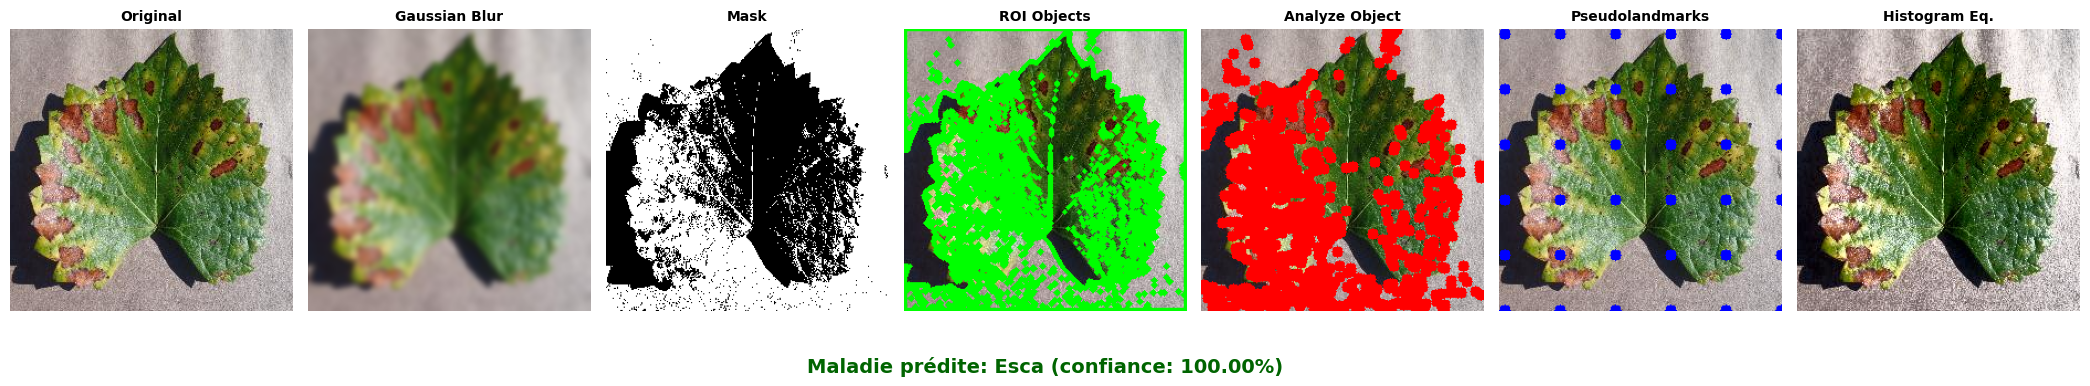


=== RÉSULTAT DE LA PRÉDICTION ===
Maladie: Esca
Confiance: 100.00%

Top 3 prédictions:
  Esca: 100.00%
  spot: 0.00%
  healthy: 0.00%


In [8]:
if os.path.exists(IMAGE_PATH):
    print("\n=== ANALYSE DE L'IMAGE ===")
    print(f"Image: {IMAGE_PATH}")

    predicted_label, confidence = predict_and_display(
        IMAGE_PATH, model, class_names, IMAGE_SIZE
    )
else:
    print("\nVeuillez définir IMAGE_PATH avec un chemin valide.")

## 8. Prédiction sur Plusieurs Images

In [11]:
def predict_multiple_images(image_dir, model, class_names,
                            image_size=(128, 128)):
    """
    Prédit la maladie pour toutes les images d'un dossier.
    """
    image_files = [f for f in os.listdir(image_dir)
                   if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    if not image_files:
        print(f"Aucune image trouvée dans {image_dir}")
        return

    print(f"\n=== PRÉDICTION SUR {len(image_files)} IMAGES ===")
    results = []

    for img_file in image_files:
        img_path = os.path.join(image_dir, img_file)
        image = cv2.imread(img_path)

        if image is None:
            continue

        # Prétraitement
        image_resized = cv2.resize(image, image_size)
        image_resized = image_resized.astype('float32') / 255.0
        image_resized = np.expand_dims(image_resized, axis=0)

        # Prédiction
        prediction = model.predict(image_resized, verbose=0)
        predicted_index = np.argmax(prediction)
        predicted_label = class_names[predicted_index]
        confidence = prediction[0][predicted_index] * 100

        results.append({
            'file': img_file,
            'prediction': predicted_label,
            'confidence': confidence
        })

        print(f"  {img_file}: {predicted_label} ({confidence:.2f}%)")

    return results

TEST_DIR = "../Test_split/Grape_Esca"
if os.path.exists(TEST_DIR):
    results = predict_multiple_images(TEST_DIR, model, class_names, IMAGE_SIZE)

print("\nFonction de prédiction batch définie")


=== PRÉDICTION SUR 500 IMAGES ===
  image (17).JPG: Esca (100.00%)
  image (1332).JPG: Esca (100.00%)
  image (1175).JPG: Esca (100.00%)
  image (220).JPG: Esca (100.00%)
  image (86).JPG: Esca (100.00%)
  image (975).JPG: Esca (100.00%)
  image (148).JPG: Esca (100.00%)
  image (1169).JPG: Esca (100.00%)
  image (200).JPG: Esca (100.00%)
  image (1161).JPG: Esca (100.00%)
  image (514).JPG: Esca (100.00%)
  image (1202).JPG: Esca (99.18%)
  image (955).JPG: Esca (99.65%)
  image (215).JPG: Esca (100.00%)
  image (1003).JPG: Esca (100.00%)
  image (715).JPG: Esca (100.00%)
  image (723).JPG: Esca (100.00%)
  image (412).JPG: Esca (100.00%)
  image (913).JPG: Esca (100.00%)
  image (162).JPG: Esca (99.88%)
  image (14).JPG: Esca (100.00%)
  image (409).JPG: Esca (100.00%)
  image (457).JPG: Esca (100.00%)
  image (608).JPG: Esca (100.00%)
  image (166).JPG: Esca (99.99%)
  image (678).JPG: Esca (99.99%)
  image (1367).JPG: Esca (100.00%)
  image (193).JPG: Esca (100.00%)
  image (53).J

## 9. Évaluation sur un Dataset de Test

In [12]:
def evaluate_on_test_set(test_dir, model, class_names, image_size=(128, 128)):
    """
    Évalue le modèle sur un dataset de test structuré.
    """

    y_true = []
    y_pred = []

    print("\n=== ÉVALUATION SUR DATASET DE TEST ===")

    for subdir in os.listdir(test_dir):
        path = os.path.join(test_dir, subdir)
        if not os.path.isdir(path):
            continue

        try:
            true_label = subdir.split('_', 1)[1]
            if true_label not in class_names:
                continue

            files = [f for f in os.listdir(path)
                     if f.lower().endswith(('.jpg'))]

            for file in files:
                img_path = os.path.join(path, file)
                image = cv2.imread(img_path)

                if image is None:
                    continue

                # Prétraitement
                image_resized = cv2.resize(image, image_size)
                image_resized = image_resized.astype('float32') / 255.0
                image_resized = np.expand_dims(image_resized, axis=0)

                # Prédiction
                prediction = model.predict(image_resized, verbose=0)
                predicted_label = class_names[np.argmax(prediction)]

                y_true.append(true_label)
                y_pred.append(predicted_label)

        except ValueError:
            continue

    if not y_true:
        print("Aucune prédiction effectuée. Vérifiez la structure du dossier.")
        return

    # Calcul de la précision
    accuracy = accuracy_score(y_true, y_pred)
    print(f"\nPrécision sur le test set: {accuracy * 100:.2f}%")
    print(f"Total d'images testées: {len(y_true)}")

    # Rapport de classification
    print("\n=== RAPPORT DE CLASSIFICATION ===")
    print(classification_report(y_true, y_pred))

TEST_DATASET = "../Test_split/"
if os.path.exists(TEST_DATASET):
    evaluate_on_test_set(TEST_DATASET, model, class_names, IMAGE_SIZE)

print("\nFonction d'évaluation définie")


=== ÉVALUATION SUR DATASET DE TEST ===

Précision sur le test set: 99.60%
Total d'images testées: 2000

=== RAPPORT DE CLASSIFICATION ===
              precision    recall  f1-score   support

   Black_rot       1.00      1.00      1.00       500
        Esca       1.00      0.99      0.99       500
     healthy       0.99      1.00      1.00       500
        spot       1.00      1.00      1.00       500

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000


Fonction d'évaluation définie


## 10. Visualisation des Prédictions Incorrectes

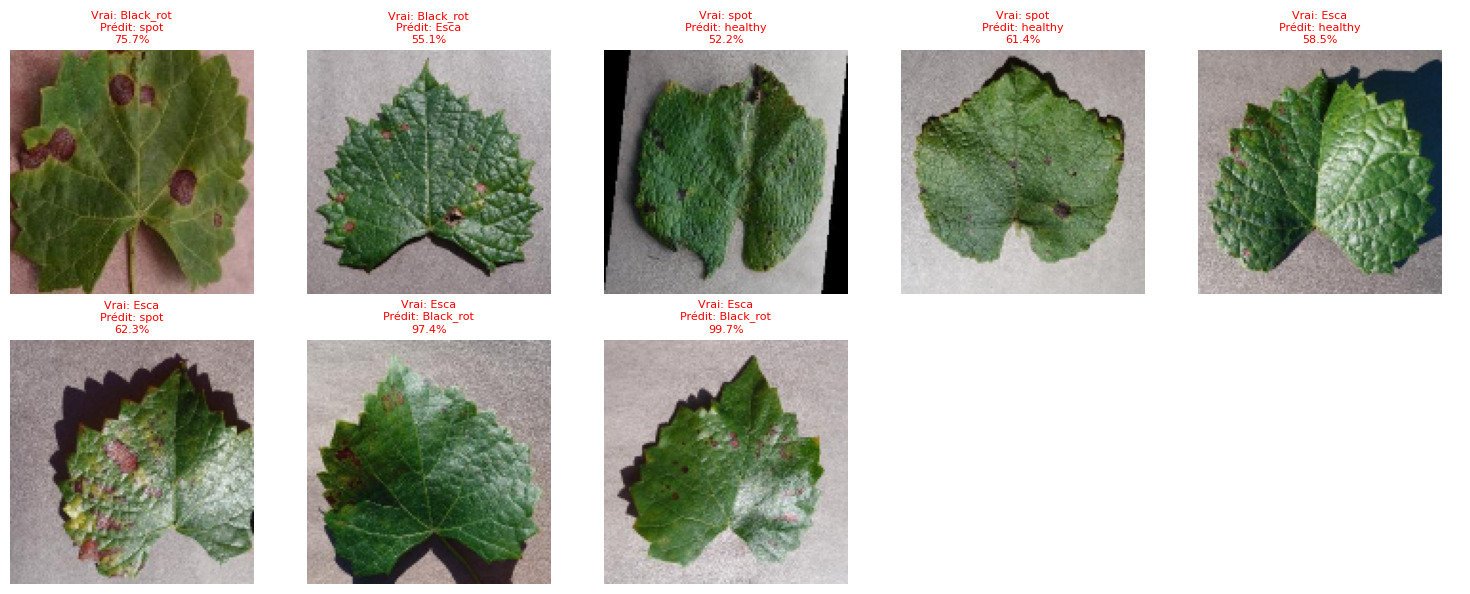


8 prédictions incorrectes affichées

Fonction de visualisation définie


In [13]:
def visualize_incorrect_predictions(test_dir, model, class_names,
                                    image_size=(128, 128), max_display=10):
    """
    Visualise les prédictions incorrectes pour analyse.
    """
    incorrect = []

    for subdir in os.listdir(test_dir):
        path = os.path.join(test_dir, subdir)
        if not os.path.isdir(path):
            continue

        try:
            true_label = subdir.split('_', 1)[1]
            if true_label not in class_names:
                continue

            files = [f for f in os.listdir(path)
                     if f.lower().endswith(('.jpg'))]

            for file in files:
                if len(incorrect) >= max_display:
                    break

                img_path = os.path.join(path, file)
                image = cv2.imread(img_path)

                if image is None:
                    continue

                # Prédiction
                image_resized = cv2.resize(image, image_size)
                image_resized_norm = image_resized.astype('float32') / 255.0
                image_resized_norm = np.expand_dims(image_resized_norm, axis=0)

                prediction = model.predict(image_resized_norm, verbose=0)
                predicted_label = class_names[np.argmax(prediction)]
                confidence = np.max(prediction) * 100

                if predicted_label != true_label:
                    incorrect.append({
                        'image': cv2.cvtColor(image_resized,
                                              cv2.COLOR_BGR2RGB),
                        'true': true_label,
                        'predicted': predicted_label,
                        'confidence': confidence
                    })

        except ValueError:
            continue

    if not incorrect:
        print("\nAucune prédiction incorrecte trouvée!")
        return

    # Affichage
    n_cols = 5
    n_rows = (len(incorrect) + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 3*n_rows))
    axes = axes.flatten() if n_rows > 1 else [axes]

    for i, item in enumerate(incorrect):
        axes[i].imshow(item['image'])
        axes[i].set_title(f"Vrai: {item['true']}\nPrédit: "
                          f"{item['predicted']}\n{item['confidence']:.1f}%",
                          fontsize=8, color='red')
        axes[i].axis('off')

    for i in range(len(incorrect), len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

    print(f"\n{len(incorrect)} prédictions incorrectes affichées")

if os.path.exists(TEST_DATASET):
    visualize_incorrect_predictions(TEST_DATASET,
                                    model,
                                    class_names,
                                    IMAGE_SIZE)

print("\nFonction de visualisation définie")